<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [3]:
!pip install phik -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import shapiro
import statistics
from sklearn.model_selection import train_test_split
import phik

from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from time import time
import phik
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings(action='ignore')



RANDOM_STATE = 42
TEST_SIZE = 0.1

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (10,10)

In [5]:
def create_boxplot_and_histogram(data, column):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # График ящика с усами
    sns.boxplot(x=data[column], ax=axes[0])
    axes[0].set_title(f'Ящик с усами для {column}')
    axes[0].set_xlabel(column)

    # Гистограмма
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    sns.histplot(data=data, x=column, kde=True, bins=num_bins, ax=axes[1])
    axes[1].set_title(f'{column} - Частота распределения', fontsize=18)
    axes[1].set_xlabel(column, fontsize=14)
    axes[1].set_ylabel('Частота', fontsize=14)

    plt.show()

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    df = data.copy()
    return df

In [7]:
def evaluate_pipeline(pipeline, param_grid, X_train, y_train):

    tscv = TimeSeriesSplit(n_splits=3)
    grid_search = RandomizedSearchCV(
                    pipeline,
                    param_grid,
                    n_jobs=-1,
                    cv=tscv,
                    scoring='neg_root_mean_squared_error',
                    random_state=RANDOM_STATE)


    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    rmse = abs(grid_search.best_score_)

    return best_params, rmse, best_model

In [8]:
def evaluate_time(pipeline, X_train, y_train):
    start_time = time()

    pipeline.fit(X_train, y_train)

    end_time = time()
    execution_time = end_time - start_time
    return execution_time

In [9]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    print('Ошибка')

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Датасет имеет 4416 записей, пропусков нет.

Установим индекс таблицы равным столбцу datetime

In [13]:
#df.index.is_monotonic


In [14]:
df = df.resample('1H').sum()

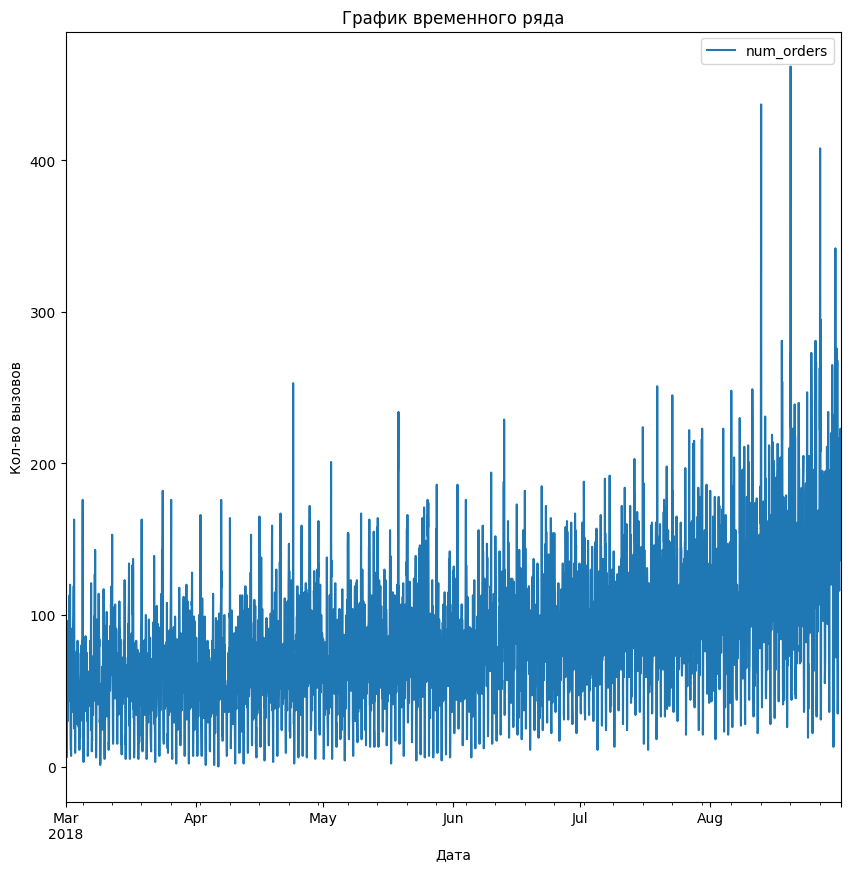

In [15]:
df.plot()
plt.title('График временного ряда')
plt.xlabel('Дата')
plt.ylabel('Кол-во вызовов');
#plt.rcParams["figure.figsize"] = (10,10)

## Анализ


Построим график трендовой составляющей с марта по август

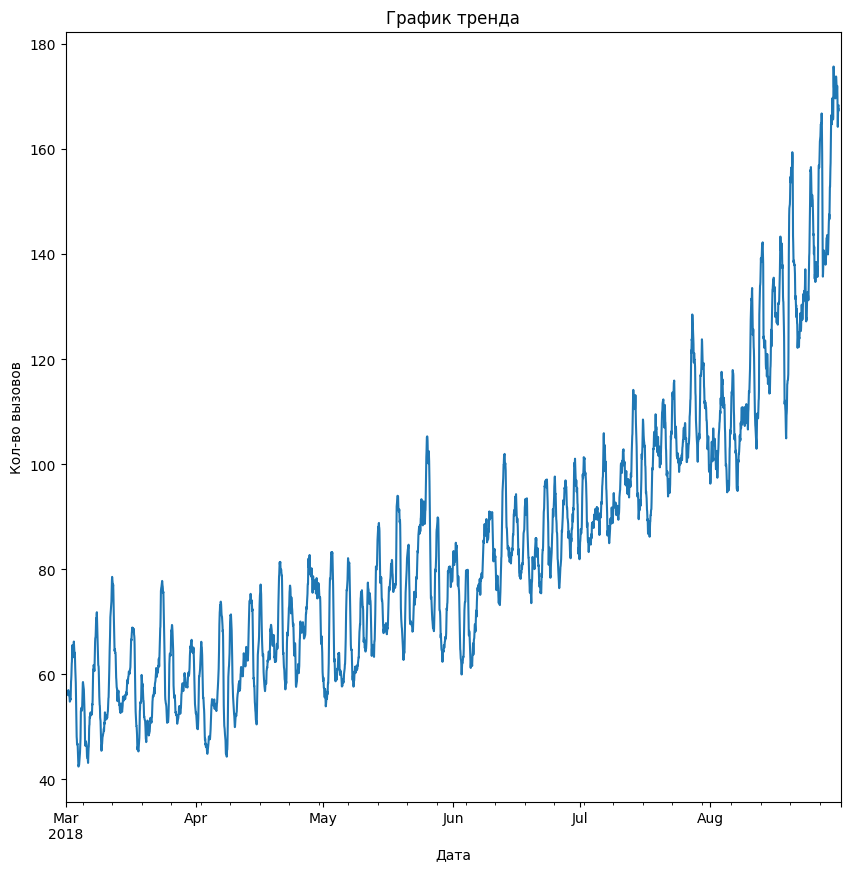

In [16]:
decomposed = seasonal_decompose(df)

decomposed.trend['2018-03-01':'2018-08-31'].plot()
plt.title('График тренда')
plt.xlabel('Дата')
plt.ylabel('Кол-во вызовов');

Возьмем промежуток 3 дня и посмотрим сезонною составляющую графика

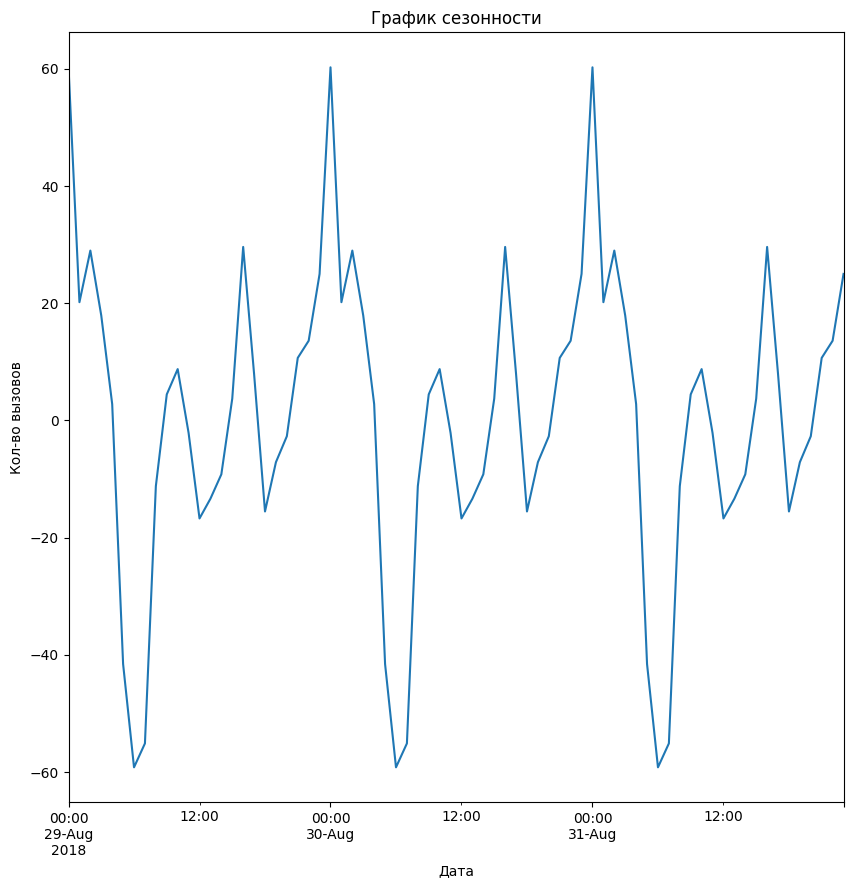

In [17]:
decomposed.seasonal['2018-08-29':'2018-08-31'].plot()
plt.title('График сезонности')
plt.xlabel('Дата')
plt.ylabel('Кол-во вызовов');

С 6 утра количество заказов увеличивается и достигает пикого значения примерно в полночь

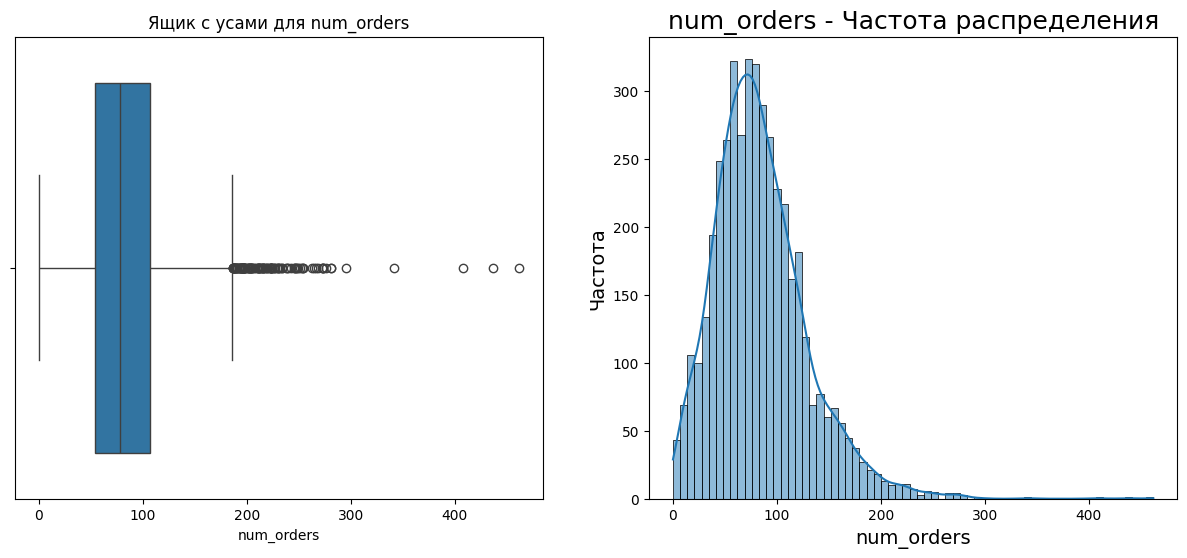

In [18]:
create_boxplot_and_histogram(df, 'num_orders')

In [19]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Не смотря на то, что присутствуют аномалии, мы не будем их удалять, так как скорей всего это пиковые значения в самые загруженные дни, и они будут полезны для обучения

In [20]:
#df = df.query('num_orders < 200')

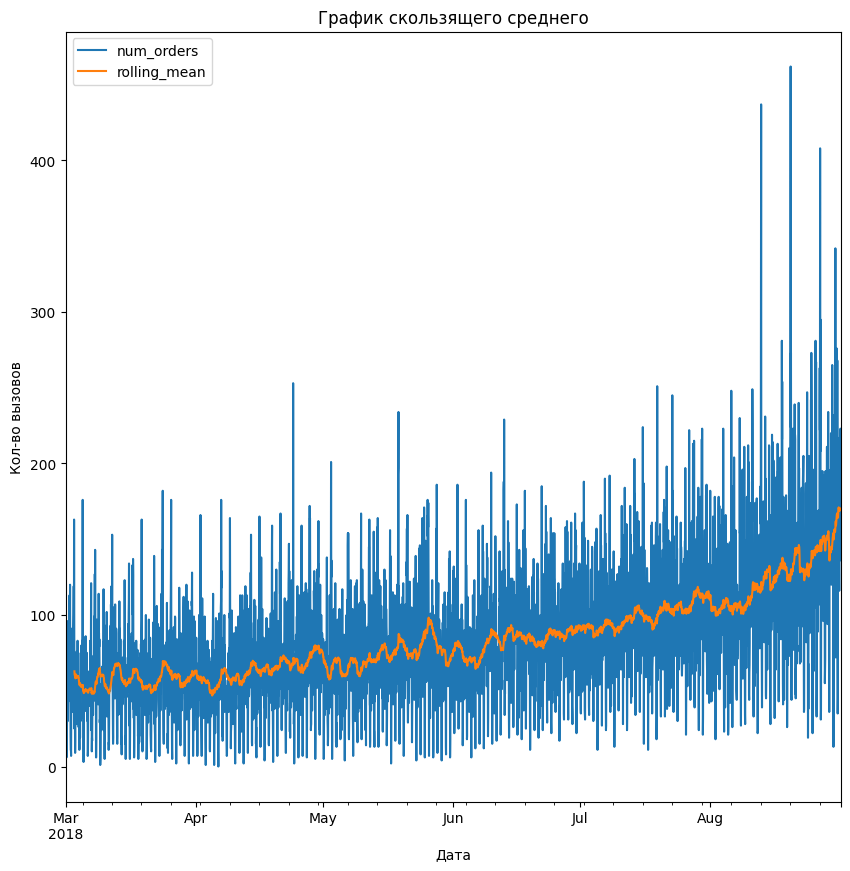

In [21]:
df_roll = df.copy()

df_roll['rolling_mean'] = df_roll['2018-03-01':'2018-08-31'].shift().rolling(50).mean()
df_roll.plot()
plt.title('График скользящего среднего')
plt.xlabel('Дата')
plt.ylabel('Кол-во вызовов');


По графику скользящего среднего видно, что количество вызовов увеличивает с приближением осени, что скорей всего связано с временем отпусков, когда люди чаще возвращаются с отдыха.
Т.к среднее значение увеличивается со временем - следовательно ряд является нестационарным и его прогнозировать сложнее.
Сделаем ряд стационарным, найдём разности его значений.

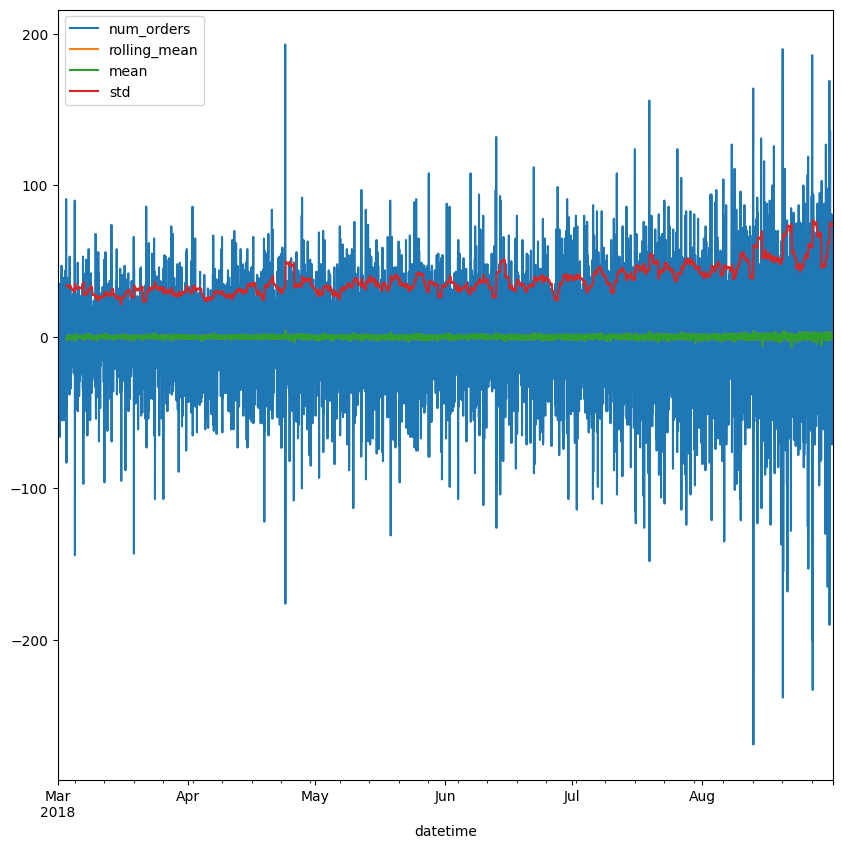

In [22]:
df_roll = df_roll - df_roll.shift()
df_roll['mean'] = df_roll['num_orders'].shift().rolling(50).mean()
df_roll['std'] = df_roll['num_orders'].shift().rolling(50).std()

df_roll.plot();

In [23]:
data = make_features(df, 20, 10)

**Вывод**
Построили графики сезонности и тренда, из них видно:
- Начиная с марта количество заказов растет
- заметная суточная сезонность: минимум заказов приходится на 6:00, а пик в полночь

Также была построен график скользящего среднего, по которому видно, что временной ряд является нестационарным

## Обучение

Выполним кодировку признаков. Для количественных StandardScaler

In [26]:
data.dropna(inplace=True)
target = data['num_orders']
matrix = data.drop('num_orders', axis=1)

matrix_train, matrix_test, target_train, target_test = train_test_split(
    matrix, target,
    shuffle=False,
    random_state=RANDOM_STATE,
    test_size=0.1)

num_col = matrix.columns

In [27]:

numeric_pipe = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipe, num_col)
], remainder='passthrough')

## Тестирование

Исследуем 3 модели. Возьмем дерево решений как более простую модель и 2 модели градиентного бустинга. Для исследования и выбора лучшей модели выберем метрику RMSE, а также будем смотреть на время обучения модели. Все эти данные сохраним в датафрейм для удобства

# DecisionTreeRegressor

In [28]:
pipeline_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ("decision_tree", DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# Определение параметров для поиска
param_grid_tree = {
    'decision_tree__max_depth': [3, 5, 7],
    'decision_tree__min_samples_split': [2, 3, 4],
    'decision_tree__min_samples_leaf': [1, 2, 3]
}

execution_time_tree = evaluate_time(pipeline_tree, matrix_train, target_train)

best_params_tree, rmse_tree, model_tree = \
evaluate_pipeline(pipeline_tree, param_grid_tree, matrix_train, target_train)


#best_params_tree, execution_time_tree, rmse_tree, model_tree, prediction_time_tree = \
#evaluate_pipeline(pipeline_tree, param_grid_tree, matrix_train, target_train)


# CatBoostRegressor

In [29]:
pipeline_catboost = Pipeline([
    ('preprocessor', data_preprocessor),
    ("catboost", CatBoostRegressor(loss_function='RMSE', verbose=25, random_state=RANDOM_STATE))
])

In [30]:
param_grid_catboost = {
    'catboost__iterations': [50, 100, 150]
}

execution_time_catboost = evaluate_time(pipeline_catboost, matrix_train, target_train)

best_params_catboost, rmse_catboost, model_catboost = \
evaluate_pipeline(pipeline_catboost, param_grid_catboost, matrix_train, target_train)

Learning rate set to 0.05088
0:	learn: 38.0929041	total: 53.9ms	remaining: 53.9s
25:	learn: 29.8163047	total: 177ms	remaining: 6.61s
50:	learn: 27.0833333	total: 300ms	remaining: 5.58s
75:	learn: 25.8444618	total: 422ms	remaining: 5.13s
100:	learn: 24.7526362	total: 547ms	remaining: 4.87s
125:	learn: 24.0372608	total: 676ms	remaining: 4.69s
150:	learn: 23.5022604	total: 803ms	remaining: 4.51s
175:	learn: 22.7498288	total: 927ms	remaining: 4.34s
200:	learn: 22.1484683	total: 1.05s	remaining: 4.17s
225:	learn: 21.4836009	total: 1.17s	remaining: 4.01s
250:	learn: 20.9557250	total: 1.29s	remaining: 3.86s
275:	learn: 20.4563876	total: 1.41s	remaining: 3.7s
300:	learn: 20.0229510	total: 1.53s	remaining: 3.57s
325:	learn: 19.5998249	total: 1.67s	remaining: 3.46s
350:	learn: 19.1600561	total: 1.8s	remaining: 3.32s
375:	learn: 18.7674164	total: 1.92s	remaining: 3.19s
400:	learn: 18.3850262	total: 2.04s	remaining: 3.04s
425:	learn: 18.0510298	total: 2.15s	remaining: 2.9s
450:	learn: 17.7065664	t

# LGBMRegressor

In [31]:
pipeline_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ("lgbm", LGBMRegressor(random_state=RANDOM_STATE))
])

In [32]:
param_grid_lgbm = {
    'lgbm__max_depth': [3, 5, 7]
}

execution_time_lgbm = evaluate_time(pipeline_lgbm, matrix_train, target_train)

best_params_lgbm, rmse_lgbm, model_lgbm  = \
evaluate_pipeline(pipeline_lgbm, param_grid_lgbm, matrix_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4091
[LightGBM] [Info] Number of data points in the train set: 3956, number of used features: 23
[LightGBM] [Info] Start training from score 78.447422
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4091
[LightGBM] [Info] Number of data points in the train set: 3956, number of used features: 23
[LightGBM] [Info] Start training from score 78

In [33]:
data1 = {
    "model": ['tree', 'catboost', 'lgbm'],
    "execution_time": [execution_time_tree, execution_time_catboost, execution_time_lgbm],
    "train_rmse": [rmse_tree, rmse_catboost, rmse_lgbm]
}

df_all_model = pd.DataFrame(data1)

df_all_model.head()

,model,execution_time,train_rmse
0,tree,0.336696,36.453233
1,catboost,5.168192,30.723891
2,lgbm,0.329356,31.192511


По результатам исследования лучшая модель по RMSE метрике LGBMRegressor. И она же почти самая быстрая по времени обучения. Посмотрим на ее гиперпараметры и выполним предсказание на тестовой выборке

In [34]:
best_params_lgbm

{'lgbm__max_depth': 7}

In [35]:
predictions = model_lgbm.predict(matrix_test)
rmse_test = mean_squared_error(target_test, predictions, squared=False)
rmse_test

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


47.00547148617672

# Вывод
В ходе предобработки было сделано:

* загрузили данный
* удалили аномальны значения

В ходе подготовки данных к обучению было сделано:
* Разделили данные на тренировочную и тестовую выборку
* Выбрали кодировщик StandartScaler

В ходе обучения было сделано следующее:
* Для обучения выбрали 3 модели DecisionTreeRegressor, CatBoostRegressor, Light Gradient Boosting Machine
* По метрике RMSE  выбрали модель LGBMRegressor и выполнили предсказание на тестовых данных

Модель LGBMRegressor:

* train_rmse 1.25
* execution_time 5.69 сек.
* lgbm__max_depth: 5

Значение RMSE лучшей модели на тестовой выборке - 47.9